In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
fero = pd.read_csv("FOE.csv")

In [3]:
#Taking a look at our data
fero.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-03-17,0.0,2.722222,2.685185,2.685185,1.450476,47925
1,1980-03-18,0.0,2.703704,2.666667,2.685185,1.450476,77625
2,1980-03-19,0.0,2.703704,2.666667,2.703704,1.460480,35775
3,1980-03-20,0.0,2.777778,2.703704,2.722222,1.470483,42525
4,1980-03-21,0.0,2.777778,2.740741,2.740741,1.480487,37125


In [4]:
#numerical value summary statistics
fero[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].describe()

,Open,High,Low,Close,Adj Close,Volume
count,10590.000000,10590.000000,10590.000000,10590.000000,10590.000000,1.059000e+04
mean,13.607281,14.631222,14.240872,14.439353,11.952665,3.662785e+05
std,8.521814,7.381201,7.230212,7.309994,6.597625,6.056098e+05
min,0.000000,1.010000,0.810000,0.860000,0.860000,0.000000e+00
25%,7.072500,7.740000,7.420000,7.611111,5.995661,7.695000e+04
50%,14.860000,15.080000,14.666667,14.865000,12.818146,1.966500e+05
75%,20.610001,20.847500,20.333332,20.620001,17.534573,4.675750e+05
max,30.250000,30.937500,30.000000,30.549999,25.350000,2.044590e+07


In [5]:
#converting the Date into datetime
fero.Date = pd.to_datetime(fero.Date, format='%Y-%m-%d')
fero.Close = fero.Close.astype(float)

In [6]:
#Five year subset with ontly Date and Close columns
fero_sub = fero[['Date', 'Close']]
fero_sub = fero_sub.loc[(fero_sub['Date'] >= '2016-01-01')]
fero_sub.index = fero_sub.Date

In [7]:
fero_sub

,Date,Close
Date,,
2016-01-04,2016-01-04,10.750000
2016-01-05,2016-01-05,10.580000
2016-01-06,2016-01-06,10.050000
2016-01-07,2016-01-07,9.520000
2016-01-08,2016-01-08,9.610000
...,...,...
2022-03-09,2022-03-09,21.780001
2022-03-10,2022-03-10,21.790001
2022-03-11,2022-03-11,21.780001


In [8]:
#extracting days, month and year
fero_sub['year'] = fero_sub.Date.dt.year
fero_sub['month'] = fero_sub.Date.dt.month
fero_sub['day'] = fero_sub.Date.dt.day
fero_sub.head()

,Date,Close,year,month,day
Date,,,,,
2016-01-04,2016-01-04,10.75,2016,1,4
2016-01-05,2016-01-05,10.58,2016,1,5
2016-01-06,2016-01-06,10.05,2016,1,6
2016-01-07,2016-01-07,9.52,2016,1,7
2016-01-08,2016-01-08,9.61,2016,1,8


<AxesSubplot:xlabel='year'>

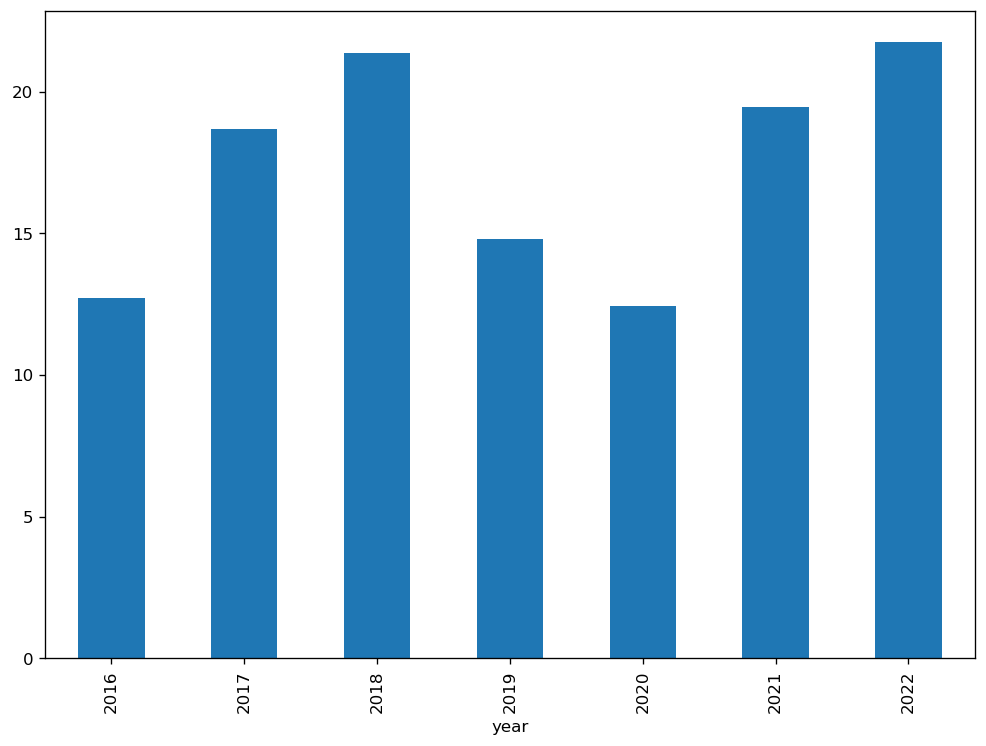

In [9]:
#Average price per year
fero_sub.groupby('year').Close.mean().plot.bar()

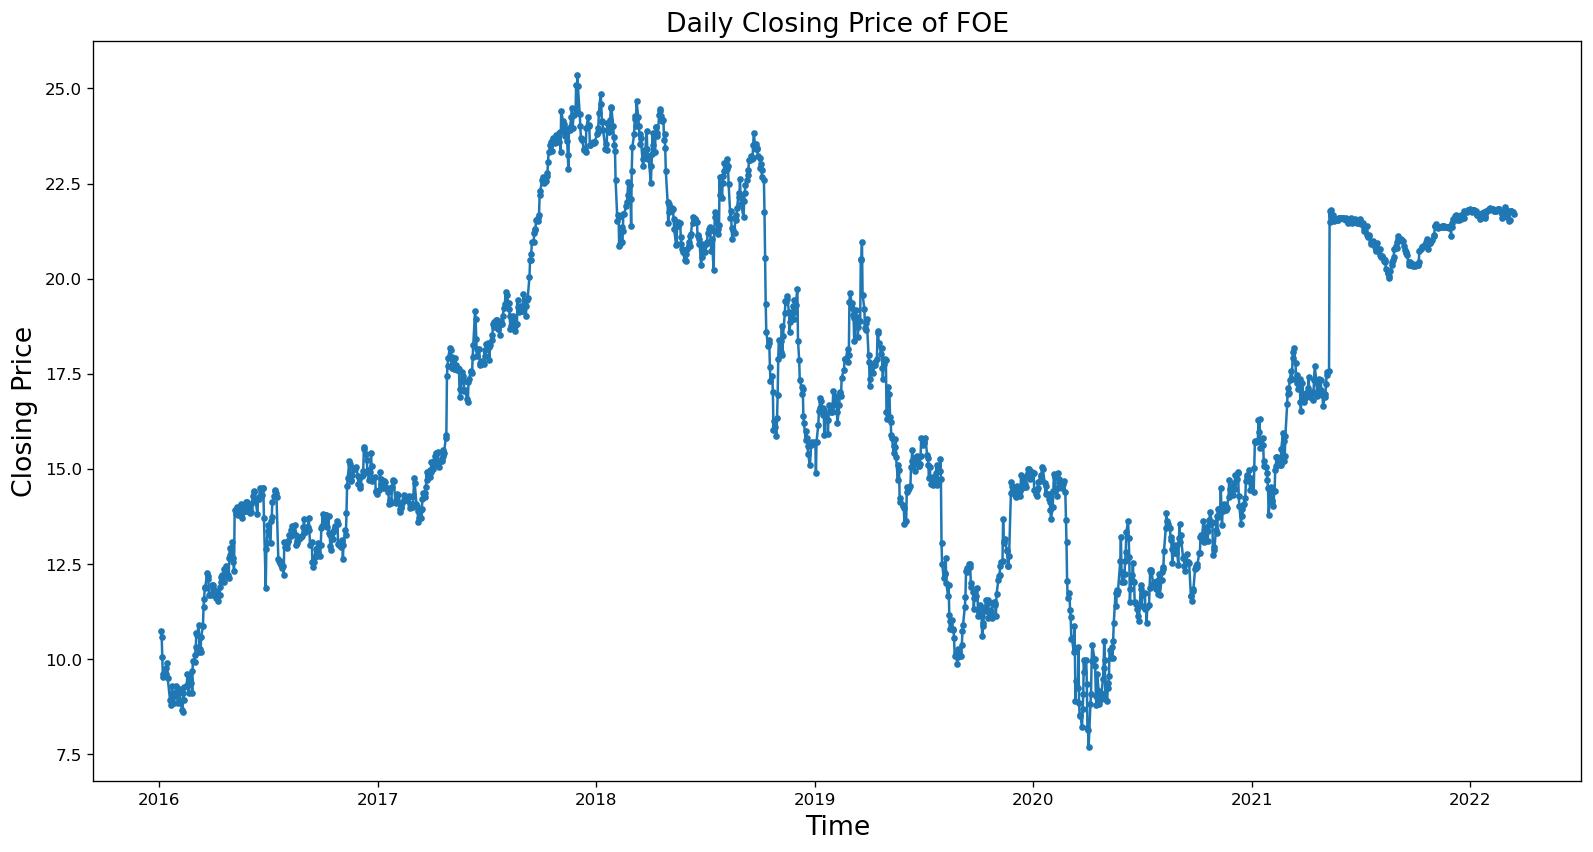

In [10]:
#function to plot a line graph
def line_g(df,x,y,title):
    plt.figure(figsize=(16,8))
    plt.plot(x, y, ".-", data = df)
    plt.title(title, fontsize = 16)
    plt.xlabel("Time", fontsize = 16)
    plt.ylabel("Closing Price", fontsize = 16)
line_g(fero_sub,'Date', 'Close', "Daily Closing Price of FOE")

In [11]:
monthly = fero_sub.resample('M').mean()
monthly

,Close,year,month,day
Date,,,,
2016-01-31,9.480526,2016.0,1.0,16.421053
2016-02-29,9.226000,2016.0,2.0,14.200000
2016-03-31,11.237727,2016.0,3.0,15.590909
2016-04-30,12.100000,2016.0,4.0,15.761905
2016-05-31,13.685238,2016.0,5.0,15.285714
...,...,...,...,...
2021-11-30,21.331429,2021.0,11.0,14.476190
2021-12-31,21.642727,2021.0,12.0,16.000000
2022-01-31,21.720500,2022.0,1.0,16.200000


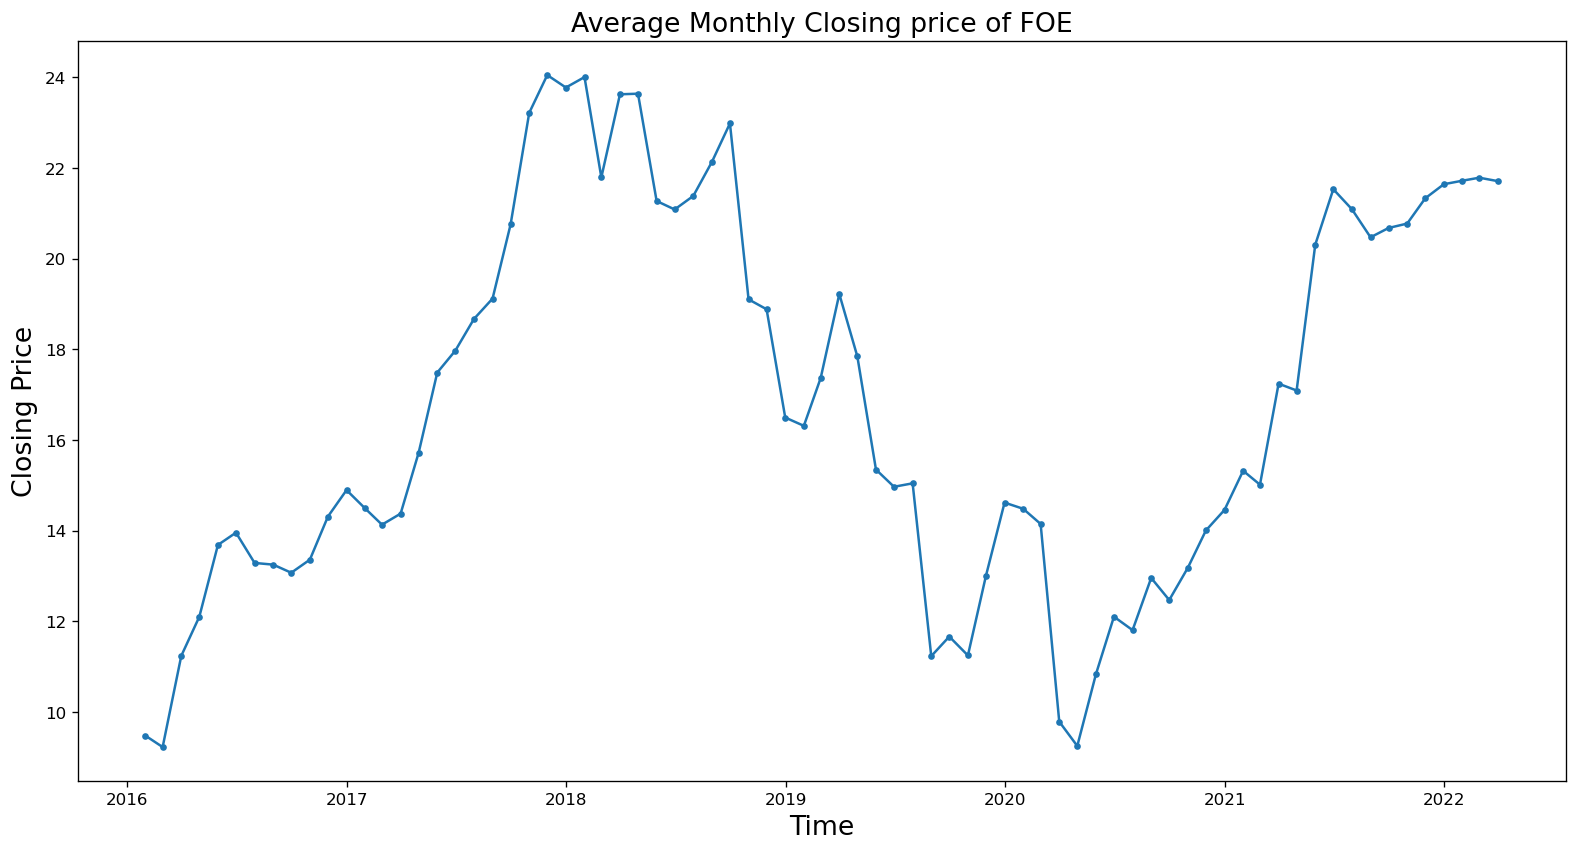

In [12]:
line_g(monthly, monthly.index, 'Close', "Average Monthly Closing price of FOE")

In [13]:
#monthly subset
monthly_sub = monthly.loc[(monthly.index <= '2021-01-01')]
len(monthly_sub)

60

In [14]:
monthly_sub.head()

,Close,year,month,day
Date,,,,
2016-01-31,9.480526,2016.0,1.0,16.421053
2016-02-29,9.226000,2016.0,2.0,14.200000
2016-03-31,11.237727,2016.0,3.0,15.590909
2016-04-30,12.100000,2016.0,4.0,15.761905
2016-05-31,13.685238,2016.0,5.0,15.285714


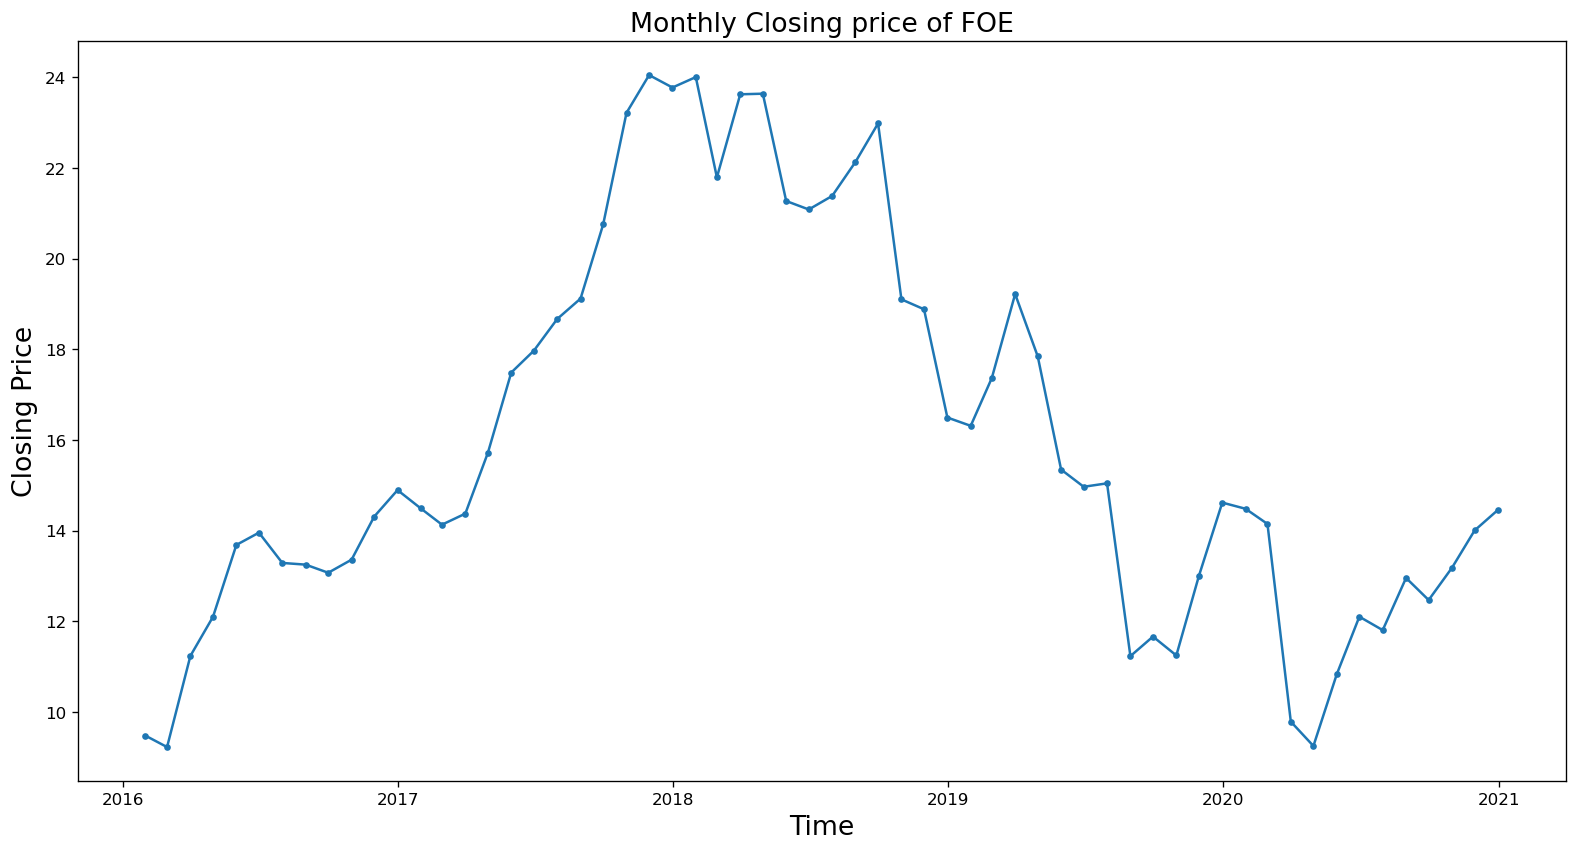

In [15]:
line_g(monthly_sub, monthly_sub.index, 'Close', "Monthly Closing price of FOE")

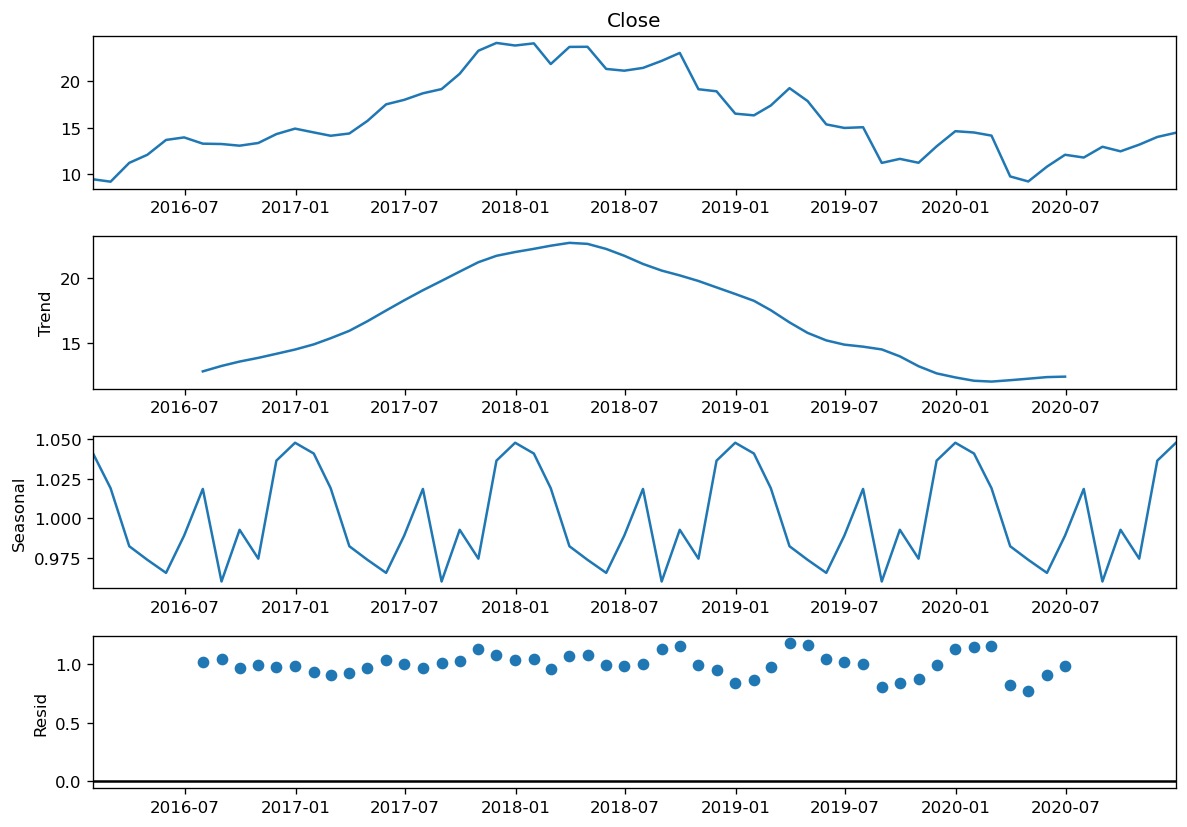

In [16]:
#Decompose the time series to check for seasonality
decomposition_m = sm.tsa.seasonal_decompose(monthly_sub['Close'], model='multiplicative')
fig = decomposition_m.plot()
plt.show()

There is strong evidence of seasonality within the average monthly stock price where there tendency for the price to increase approaching summer and winter. This implies that these are the months the stock performs well which is to be expected as those are when the purchases for sweets are most likely to happen.

In [17]:
# DF Test using statsmodels adfuller
#this is a test where H0: There is a unit root and the time series is non-stationary / 
#H1: there is no unit root and the data is stationary. 
from statsmodels.tsa.stattools import adfuller

def df_test(time_series):
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(time_series, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    
    print (dfoutput)
df_test(monthly_sub.Close)

Results of Dickey-Fuller Test:
Test Statistic                 -1.731903
p-value                         0.414755
#Lags Used                      0.000000
Number of Observations Used    59.000000
Critical Value (1%)            -3.546395
Critical Value (5%)            -2.911939
Critical Value (10%)           -2.593652
dtype: float64


As the p-value > 0.05, I fail to reject the null hypothesis which means that the data is non-stationary. The next step is to make the data stationary in order to comply with the assumptions of ARIMA. In order to do this, I will use first order differencing.

In [18]:
# Differencing
monthly_diff = monthly_sub.diff().dropna()
df_test(monthly_diff.Close)

Results of Dickey-Fuller Test:
Test Statistic                -6.511578e+00
p-value                        1.097050e-08
#Lags Used                     0.000000e+00
Number of Observations Used    5.800000e+01
Critical Value (1%)           -3.548494e+00
Critical Value (5%)           -2.912837e+00
Critical Value (10%)          -2.594129e+00
dtype: float64


After first order differencing, the ADF test shows that we now have evidence to reject the null hypothesis. In other words, we find no presence of a unit root and therefore the data is stationary. We must now find the best ARIMA parameters.

In [22]:
#Using auto_arima, the order and seasonal order is found.
from pmdarima import auto_arima

foe_arima = auto_arima(monthly_diff.Close, X=None, start_p=0, d=None, start_q=0, max_p=5, max_d=5, max_q=5, start_P=0, D=None, 
                       start_Q=0, max_P=5, max_D=5, max_Q=5, max_order=5, m=1, seasonal=True, stationary=True, 
                       information_criterion='aic', alpha=0.05, test='kpss', seasonal_test='ocsb', stepwise=False, 
                       n_jobs=10, start_params=None, trend=None, method='lbfgs', maxiter=50, offset_test_args=None, 
                       seasonal_test_args=None, suppress_warnings=True, error_action='trace', trace=False, 
                       random=False, random_state=None, n_fits=10, return_valid_fits=False, out_of_sample_size=0, 
                       scoring='mse', scoring_args=None, with_intercept='auto', sarimax_kwargs=None)

arima_order = foe_arima.order
seasonal_order = foe_arima.seasonal_order

print(foe_arima.summary()) #according to the summary, the best model to use for forecast is a SARIMAX model
print("ARIMA order:", arima_order)
print("Seasonal order:", seasonal_order)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   59
Model:                        SARIMAX   Log Likelihood                -104.837
Date:                Mon, 24 Apr 2023   AIC                            213.673
Time:                        16:13:17   BIC                            217.828
Sample:                             0   HQIC                           215.295
                                 - 59                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0844      0.242      0.348      0.728      -0.390       0.559
sigma2         2.0460      0.366      5.585      0.000       1.328       2.764
Ljung-Box (L1) (Q):                   1.18   Jarque-

In [23]:
#Fit the model
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(monthly_diff.Close, order=arima_order, seasonal_order=(0, 0, 0, 12), enforce_stationarity=False, 
                enforce_invertibility=False)
results = model.fit()

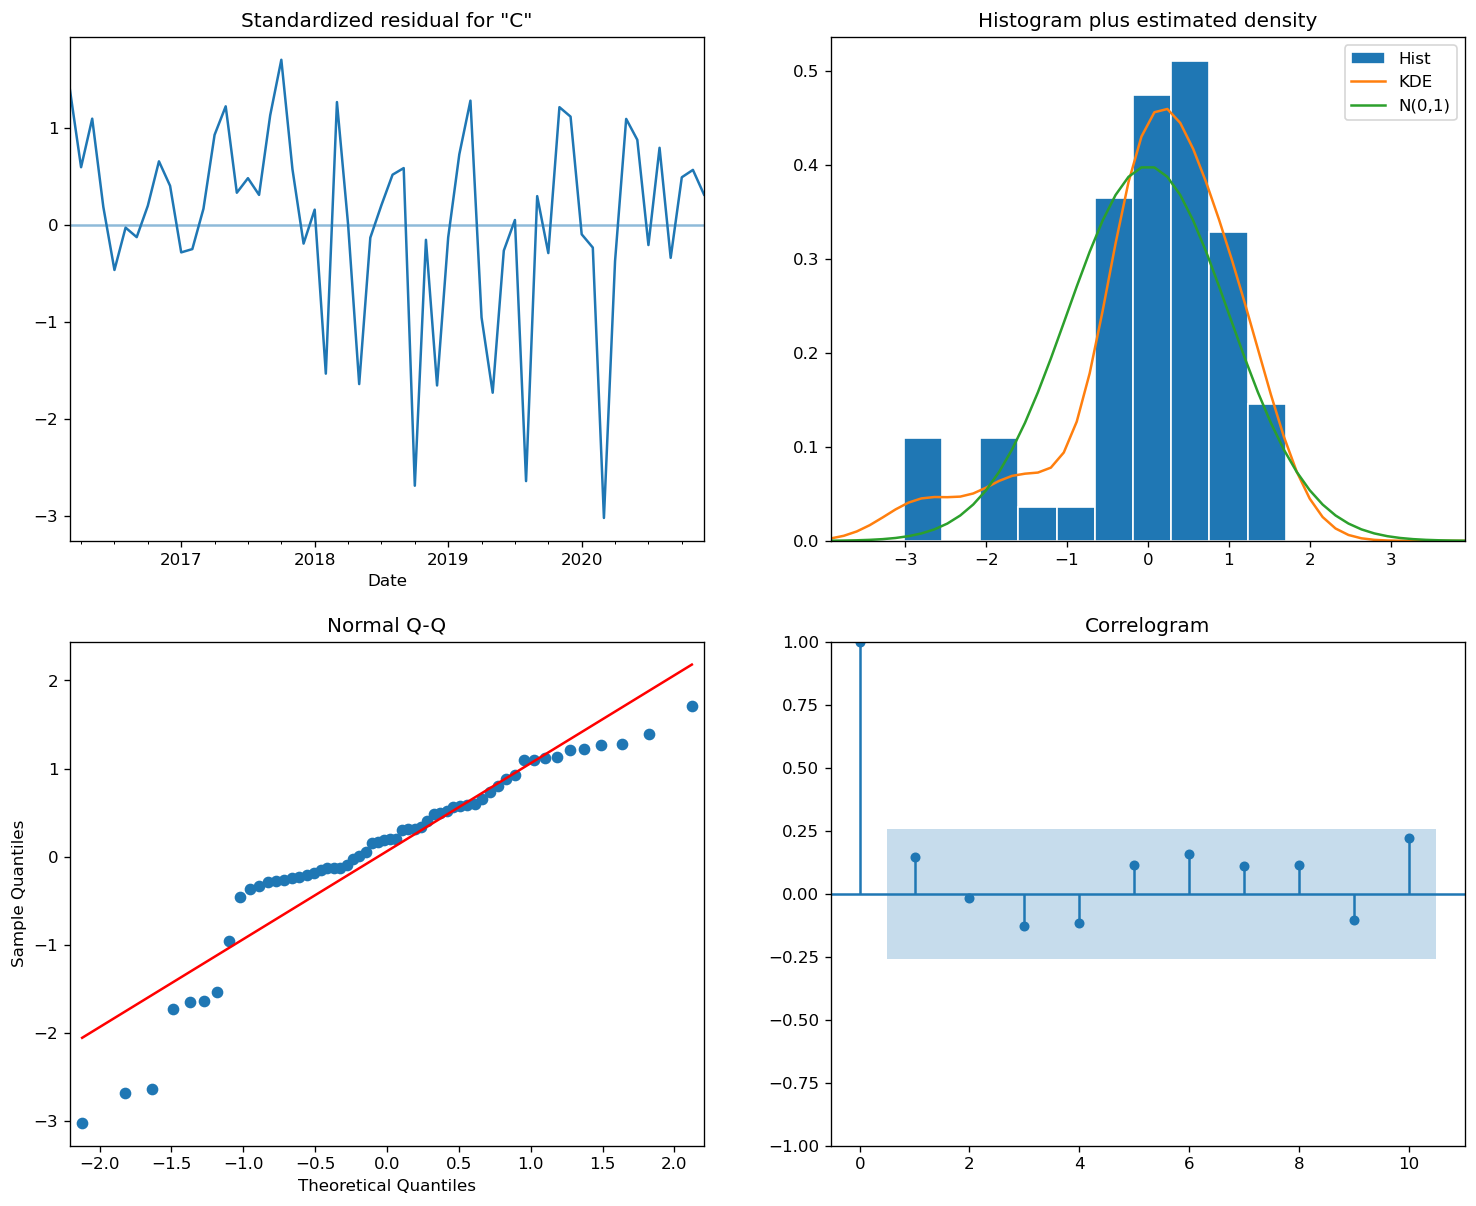

In [24]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Looking at the correlogram, time lags of 1 to 10 seems to imply that the monthly average stock price of FOE is stationary and that there seems to be no strong autocorrelation. The closing price also seems to be normally distributed as we can see from both the histogram and the residuals graph. The residuals graph shows no discernable pattern implying that there is no autocorrelation left. I can now use the data for frecasting.

In [25]:
# forecasting 3 months ahead
forecast = results.get_forecast(steps=3)
forecast_conf_int = forecast.conf_int()

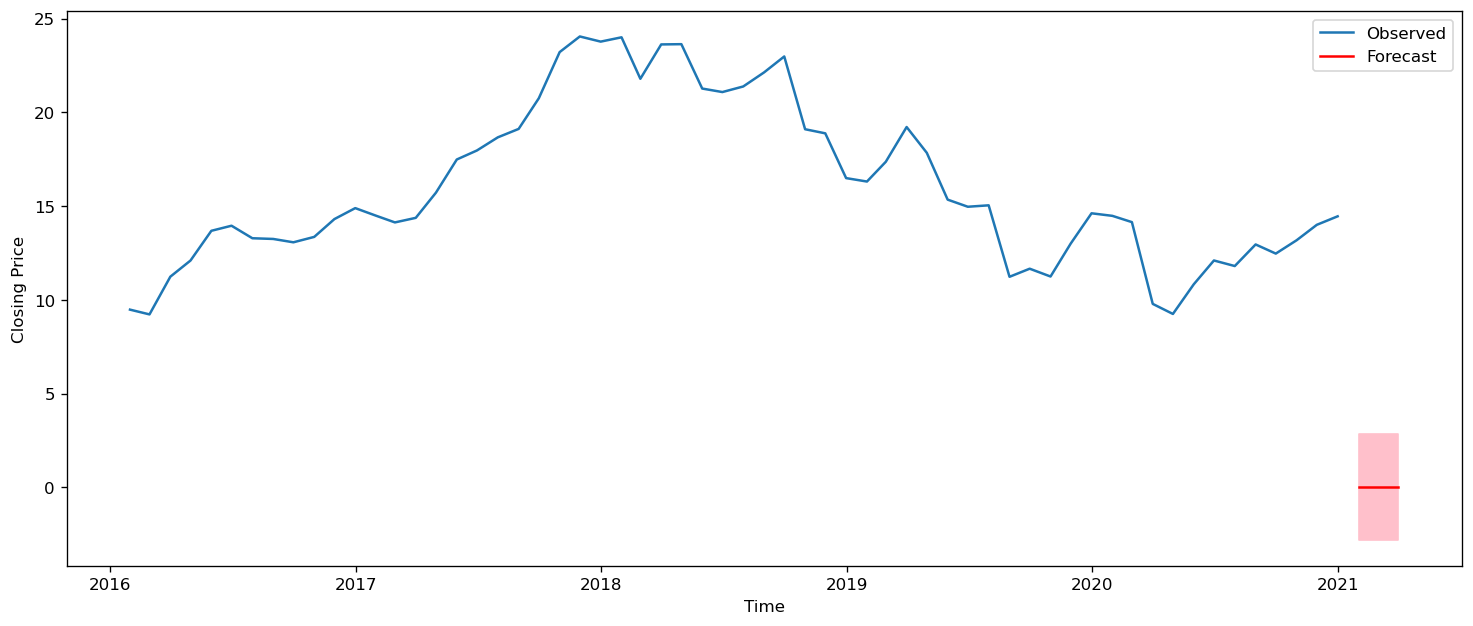

In [30]:
plt.figure(figsize=(15, 6))
plt.plot(monthly_sub.index, monthly_sub['Close'], label='Observed')
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, color='r', label='Forecast')

# Plot confidence intervals
plt.fill_between(forecast_conf_int.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink')

plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()
plt.show()